In [ ]:
## Turning handwriting to Latex.

## The code is heavily influenced by


### I
# A ten-minute-introduction-to-sequence-to-sequence-learning
# A encoder-decoder model for language translation
# URL: https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html


### II

# Genthials blog post and paper Image to Latex,

# https://guillaumegenthial.github.io/image-to-latex.html



In [1]:
#Import Numpy, Tensorflow and Keras
import numpy as np
import tensorflow as tf
from tensor2tensor.layers.common_attention import add_timing_signal_nd #currently not in use

from keras.layers import Input, LSTM, Dense, Lambda, GlobalAveragePooling1D
from keras.layers import Convolution2D, MaxPooling2D, Reshape, Flatten
from keras import layers, backend ## IS THIS BEING USED?
from keras.models import Model
import keras.backend as K


# Import our own helper functions
from prepare_data import get_decoder_data
import load_data
import preprocess_image
from load_data import get_vocabulary_size, get_vocabulary
from convolutional_encoder import get_encoded

Using TensorFlow backend.


In [23]:
## Load and process data (currently only on a small subset)

encoder_input_data, target_texts = load_data.load_data()

target_tokens = get_vocabulary()


num_decoder_tokens = len(target_tokens)

max_decoder_seq_length = max([len(txt.split()) for txt in target_texts])

target_token_index = dict(
    [(token, i) for i, token in enumerate(target_tokens)])

reverse_target_token_index = dict(
    (i, char) for char, i in target_token_index.items()) ## Will be used in the inference model

print("Maximum output sequence lenght: " + str(max_decoder_seq_length))
print("Examples of sequences: ")
print("Ex. 1: " + str(target_texts[0]))
print("Ex. 1: " + str(target_texts[1]) + "\n")

print("Number of tokens in our vocabulary: " + str(num_decoder_tokens))
print("5 example of tokens: " + str(target_tokens[0:5]) + "\n")

print("Example pairs (token, index) in dictionary: ")

for i, key in enumerate(target_token_index):
    print(key, target_token_index[key])
    if i > 3:
        break

_, image_h, image_w, _  = encoder_input_data.shape


Getting max shape
Maximum output sequence lenght: 9
Examples of sequences: 
Ex. 1: **start** \alpha + \beta **end**
Ex. 1: **start** \frac { 1 } { 2 } **end**

Number of tokens in our vocabulary: 10
5 example of tokens: ['+', '1', '2', '\\alpha', '\\beta']

Example pairs (token, index) in dictionary: 
('\\frac', 5)
('\\beta', 4)
('+', 0)
('**end**', 9)
('**start**', 8)


In [34]:
# For forced teaching, we need decoder_input data and decoder target data. 
# Decoder target data is just decoder_input_data offset by one time step.

decoder_input_data, decoder_target_data = get_decoder_data(target_texts,
                                                            target_tokens,
														 	 num_decoder_tokens,
														 	  max_decoder_seq_length,
														 	   target_token_index)

print("Each row is a one-hot encoded token in the sequence.")
print("We have 10 columns because there are 10 tokens in our vocabulary")
print("We have 9 rows, because maximum output length is 9")
print("")

print("Decoder INPUT sequence example 1")
print(decoder_input_data[0]) #Each row is a one-hot encoded token in the sequence.
print("")
print("Decoder TARGET sequence example 1 (the same as above offset by one time step)")
print(decoder_target_data[0]) #Each row is a one-hot encoded token in the sequence.



Each row is a one-hot encoded token in the sequence.
We have 10 columns because there are 10 tokens in our vocabulary
We have 9 rows, because maximum output length is 9

Decoder INPUT sequence example 1
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]

Decoder TARGET sequence example 1 (the same as above offset by one time step)
[[ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.

Latex: **start** \alpha + \beta **end**


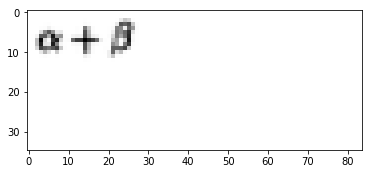

Latex: **start** \frac { 1 } { 2 } **end**


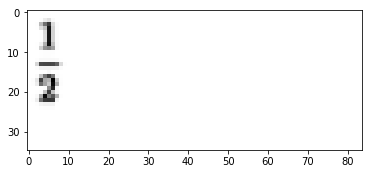

Latex: **start** \frac { \alpha } { \beta } **end**


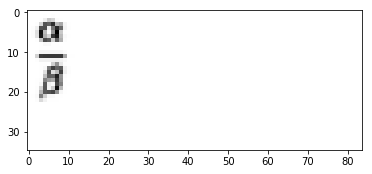

In [88]:
## Look at a few examples:

for i in range(3):

    print("Latex: " + (target_texts[i]))

    plt.imshow(encoder_input_data[i,:,:,0], cmap='gray')
    plt.show()

		sampled_token_index = np.argmax(output_tokens[0, -1, :])
		sampled_char = reverse_target_token_index[sampled_token_index]

In [94]:
## Function for debugging, going from a one_hot sequence of tokens, to the actual tokens


def from_one_hot_to_latex_sequence(one_hot_sequence):
    tokens = []
    for idx, token_vector in enumerate(one_hot_sequence):

        sampled_token_index = np.argmax(token_vector)
        sampled_char = reverse_target_token_index[sampled_token_index]

        tokens.append(sampled_char)
        if sampled_char == '**end**':
            break
    
    return tokens


latex_sequence_input = from_one_hot_to_latex_sequence(decoder_input_data[0])

latex_sequence_target = from_one_hot_to_latex_sequence(decoder_target_data[0])

print(latex_sequence_input)

print(latex_sequence_target)

['**start**', '\\alpha', '+', '\\beta', '**end**']
['\\alpha', '+', '\\beta', '**end**']


In [95]:
## Encoder step I: Encoding image into vectors (e1, e2, ..., en)

def get_encoded(image_h, image_w):

	encoder_inputs = Input(shape=(image_h, image_w,1), name="encoder_input_image")

    # Conv + max_pool / 2
	encoded = Convolution2D(filters=64, kernel_size=(3,3), padding='same', activation='relu')(encoder_inputs)
	encoded = MaxPooling2D(pool_size=2, padding='same')(encoded)

    # Conv + max_pool /2
	encoded = Convolution2D(filters=128, kernel_size=(3,3), padding='same', activation='relu')(encoded)
	encoded = MaxPooling2D(pool_size=2, padding='same')(encoded)

    # 4 Conv
	encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
	encoded = Convolution2D(filters=256, kernel_size=(3,3), padding='same', activation='relu')(encoded)
	encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='same', activation='relu')(encoded)

	encoded = Convolution2D(filters=512, kernel_size=(3,3), padding='valid', activation='relu')(encoded)

	#encoded = time_signal()(encoded)

	encoded_shape = encoded.get_shape().as_list()
	_, h, w, c = encoded_shape

    #Unroll the encoding to a series of vectors (e1, e2, e3..... en)
	encoded = Reshape((w*h, c), name="unroll_encoding")(encoded)
	
	return encoder_inputs, encoded

In [96]:
## Encoder step II: transforming (e1, e2... en) to h0 and c0 (which will go into the decoder)

# Call convolutional encoder
encoder_inputs, encoded = get_encoded(image_h, image_w)

encoded_shape = encoded.get_shape().as_list()

#Compute h0 from encoded inputs, following Genthal's suggestion

h0 = GlobalAveragePooling1D()(encoded)

h0 = Dense(512, activation='tanh', name="h0")(h0)

c0 = GlobalAveragePooling1D()(encoded)

c0 = Dense(512, activation='tanh', name="c0")(c0)

## h0, c0 are the outputs of the encoder

In [97]:
## Decoder. LSTM + Softmax layer

decoder_lstm_dim = 512

decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')

decoder_lstm = LSTM(decoder_lstm_dim, 
					return_sequences=True, 
					return_state = True,
					name="decoder_lstm")

decoder_dense = Dense(num_decoder_tokens, activation='softmax', name='decoder_softmax')

decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=[h0, c0])
decoder_outputs = decoder_dense(decoder_outputs)

In [98]:
## Putting the training model together:

model = Model([encoder_inputs, decoder_inputs], decoder_outputs)



In [99]:
# Train and save the model

model.compile(optimizer='rmsprop', loss='categorical_crossentropy') # originally 'rmsprop'

epochs = 1000
batch_size = 16

model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
			batch_size=batch_size,
			epochs=epochs,
			validation_split=0.2)

Train on 8 samples, validate on 2 samples
Epoch 1/1000
8/8 [==============================] - 2s 258ms/step - loss: 1.5363 - val_loss: 1.5793
Epoch 2/1000
8/8 [==============================] - 1s 154ms/step - loss: 1.5795 - val_loss: 1.3516
Epoch 3/1000
8/8 [==============================] - 1s 142ms/step - loss: 1.3622 - val_loss: 1.2996
Epoch 4/1000
8/8 [==============================] - 1s 139ms/step - loss: 1.3476 - val_loss: 1.1223
Epoch 5/1000
8/8 [==============================] - 1s 139ms/step - loss: 1.1672 - val_loss: 1.2480
Epoch 6/1000
8/8 [==============================] - 1s 139ms/step - loss: 1.1854 - val_loss: 1.0502
Epoch 7/1000
8/8 [==============================] - 1s 138ms/step - loss: 1.0529 - val_loss: 1.0462
Epoch 8/1000
8/8 [==============================] - 1s 139ms/step - loss: 1.0363 - val_loss: 1.0171
Epoch 9/1000
8/8 [==============================] - 1s 139ms/step - loss: 1.0272 - val_loss: 1.0068
Epoch 10/1000
8/8 [==============================] - 1s 13

Epoch 82/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.3179 - val_loss: 0.3001
Epoch 83/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.3075 - val_loss: 0.3057
Epoch 84/1000
8/8 [==============================] - 1s 138ms/step - loss: 0.3036 - val_loss: 0.2945
Epoch 85/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.3001 - val_loss: 0.3024
Epoch 86/1000
8/8 [==============================] - 1s 140ms/step - loss: 0.3009 - val_loss: 0.2929
Epoch 87/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.2974 - val_loss: 0.3124
Epoch 88/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.3050 - val_loss: 0.3197
Epoch 89/1000
8/8 [==============================] - 1s 152ms/step - loss: 0.3169 - val_loss: 0.4900
Epoch 90/1000
8/8 [==============================] - 1s 149ms/step - loss: 0.4634 - val_loss: 0.5389
Epoch 91/1000
8/8 [==============================] - 1s 140ms/step - loss: 0.5185 - val_los

Epoch 163/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.1683 - val_loss: 0.1528
Epoch 164/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.1682 - val_loss: 0.1843
Epoch 165/1000
8/8 [==============================] - 1s 141ms/step - loss: 0.1690 - val_loss: 0.1522
Epoch 166/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.1696 - val_loss: 0.1864
Epoch 167/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.1687 - val_loss: 0.1461
Epoch 168/1000
8/8 [==============================] - 1s 135ms/step - loss: 0.1671 - val_loss: 0.1886
Epoch 169/1000
8/8 [==============================] - 1s 163ms/step - loss: 0.1666 - val_loss: 0.1439
Epoch 170/1000
8/8 [==============================] - 1s 147ms/step - loss: 0.1676 - val_loss: 0.1941
Epoch 171/1000
8/8 [==============================] - 1s 151ms/step - loss: 0.1721 - val_loss: 0.2833
Epoch 172/1000
8/8 [==============================] - 1s 139ms/step - loss: 0.2420

Epoch 244/1000
8/8 [==============================] - 1s 153ms/step - loss: 0.1561 - val_loss: 0.1691
Epoch 245/1000
8/8 [==============================] - 1s 155ms/step - loss: 0.1571 - val_loss: 0.1418
Epoch 246/1000
8/8 [==============================] - 1s 157ms/step - loss: 0.1589 - val_loss: 0.1806
Epoch 247/1000
8/8 [==============================] - 1s 154ms/step - loss: 0.1607 - val_loss: 0.1427
Epoch 248/1000
8/8 [==============================] - 1s 146ms/step - loss: 0.1601 - val_loss: 0.1697
Epoch 249/1000
8/8 [==============================] - 1s 140ms/step - loss: 0.1582 - val_loss: 0.1485
Epoch 250/1000
8/8 [==============================] - 1s 141ms/step - loss: 0.1569 - val_loss: 0.1622
Epoch 251/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.1562 - val_loss: 0.1505
Epoch 252/1000
8/8 [==============================] - 1s 138ms/step - loss: 0.1559 - val_loss: 0.1607
Epoch 253/1000
8/8 [==============================] - 1s 137ms/step - loss: 0.1558

Epoch 325/1000
8/8 [==============================] - 1s 180ms/step - loss: 0.1554 - val_loss: 0.1499
Epoch 326/1000
8/8 [==============================] - 1s 182ms/step - loss: 0.1556 - val_loss: 0.1604
Epoch 327/1000
8/8 [==============================] - 1s 166ms/step - loss: 0.1554 - val_loss: 0.1516
Epoch 328/1000
8/8 [==============================] - 1s 161ms/step - loss: 0.1552 - val_loss: 0.1578
Epoch 329/1000
8/8 [==============================] - 1s 179ms/step - loss: 0.1549 - val_loss: 0.1525
Epoch 330/1000
8/8 [==============================] - 1s 173ms/step - loss: 0.1548 - val_loss: 0.1567
Epoch 331/1000
8/8 [==============================] - 1s 157ms/step - loss: 0.1547 - val_loss: 0.1526
Epoch 332/1000
8/8 [==============================] - 1s 167ms/step - loss: 0.1547 - val_loss: 0.1568
Epoch 333/1000
8/8 [==============================] - 2s 188ms/step - loss: 0.1547 - val_loss: 0.1521
Epoch 334/1000
8/8 [==============================] - 1s 156ms/step - loss: 0.1548

Epoch 406/1000
8/8 [==============================] - 1s 182ms/step - loss: 0.1605 - val_loss: 0.1485
Epoch 407/1000
8/8 [==============================] - 1s 165ms/step - loss: 0.1551 - val_loss: 0.1609
Epoch 408/1000
8/8 [==============================] - 1s 177ms/step - loss: 0.1549 - val_loss: 0.1498
Epoch 409/1000
8/8 [==============================] - 1s 168ms/step - loss: 0.1547 - val_loss: 0.1585
Epoch 410/1000
8/8 [==============================] - 1s 163ms/step - loss: 0.1545 - val_loss: 0.1510
Epoch 411/1000
8/8 [==============================] - 1s 187ms/step - loss: 0.1544 - val_loss: 0.1573
Epoch 412/1000
8/8 [==============================] - 2s 198ms/step - loss: 0.1544 - val_loss: 0.1513
Epoch 413/1000
8/8 [==============================] - 1s 169ms/step - loss: 0.1543 - val_loss: 0.1573
Epoch 414/1000
8/8 [==============================] - 1s 185ms/step - loss: 0.1543 - val_loss: 0.1509
Epoch 415/1000
8/8 [==============================] - 1s 179ms/step - loss: 0.1544

Epoch 487/1000
8/8 [==============================] - 1s 150ms/step - loss: 0.1544 - val_loss: 0.1557
Epoch 488/1000
8/8 [==============================] - 1s 148ms/step - loss: 0.1544 - val_loss: 0.1526
Epoch 489/1000
8/8 [==============================] - 1s 147ms/step - loss: 0.1543 - val_loss: 0.1560
Epoch 490/1000
8/8 [==============================] - 1s 145ms/step - loss: 0.1543 - val_loss: 0.1522
Epoch 491/1000
8/8 [==============================] - 1s 145ms/step - loss: 0.1543 - val_loss: 0.1566
Epoch 492/1000
8/8 [==============================] - 1s 159ms/step - loss: 0.1543 - val_loss: 0.1518
Epoch 493/1000
8/8 [==============================] - 1s 156ms/step - loss: 0.1543 - val_loss: 0.1569
Epoch 494/1000
8/8 [==============================] - 1s 164ms/step - loss: 0.1543 - val_loss: 0.1514
Epoch 495/1000
8/8 [==============================] - 1s 165ms/step - loss: 0.1543 - val_loss: 0.1574
Epoch 496/1000
8/8 [==============================] - 1s 158ms/step - loss: 0.1544

Epoch 568/1000
8/8 [==============================] - 1s 148ms/step - loss: 0.1544 - val_loss: 0.1536
Epoch 569/1000
8/8 [==============================] - 1s 153ms/step - loss: 0.1542 - val_loss: 0.1537
Epoch 570/1000
8/8 [==============================] - 1s 147ms/step - loss: 0.1543 - val_loss: 0.1552
Epoch 571/1000
8/8 [==============================] - 1s 147ms/step - loss: 0.1543 - val_loss: 0.1537
Epoch 572/1000
8/8 [==============================] - 1s 151ms/step - loss: 0.1544 - val_loss: 0.1539
Epoch 573/1000
8/8 [==============================] - 1s 147ms/step - loss: 0.1543 - val_loss: 0.1557
Epoch 574/1000
8/8 [==============================] - 1s 144ms/step - loss: 0.1543 - val_loss: 0.1520
Epoch 575/1000
8/8 [==============================] - 1s 154ms/step - loss: 0.1543 - val_loss: 0.1566
Epoch 576/1000
8/8 [==============================] - 1s 170ms/step - loss: 0.1543 - val_loss: 0.1524
Epoch 577/1000
8/8 [==============================] - 1s 147ms/step - loss: 0.1543

Epoch 649/1000
8/8 [==============================] - 2s 208ms/step - loss: 0.1544 - val_loss: 0.1556
Epoch 650/1000
8/8 [==============================] - 1s 167ms/step - loss: 0.1543 - val_loss: 0.1512
Epoch 651/1000
8/8 [==============================] - 1s 149ms/step - loss: 0.1546 - val_loss: 0.1577
Epoch 652/1000
8/8 [==============================] - 1s 157ms/step - loss: 0.1547 - val_loss: 0.1541
Epoch 653/1000
8/8 [==============================] - 1s 150ms/step - loss: 0.1543 - val_loss: 0.1557
Epoch 654/1000
8/8 [==============================] - 1s 154ms/step - loss: 0.1543 - val_loss: 0.1532
Epoch 655/1000
8/8 [==============================] - 1s 162ms/step - loss: 0.1544 - val_loss: 0.1554
Epoch 656/1000
8/8 [==============================] - 1s 168ms/step - loss: 0.1545 - val_loss: 0.1538
Epoch 657/1000
8/8 [==============================] - 1s 180ms/step - loss: 0.1545 - val_loss: 0.1550
Epoch 658/1000
8/8 [==============================] - 1s 161ms/step - loss: 0.1544

Epoch 730/1000
8/8 [==============================] - 2s 202ms/step - loss: 0.1541 - val_loss: 0.1527
Epoch 731/1000
8/8 [==============================] - 1s 172ms/step - loss: 0.1542 - val_loss: 0.1553
Epoch 732/1000
8/8 [==============================] - 2s 209ms/step - loss: 0.1542 - val_loss: 0.1531
Epoch 733/1000
8/8 [==============================] - 2s 200ms/step - loss: 0.1542 - val_loss: 0.1551
Epoch 734/1000
8/8 [==============================] - 1s 176ms/step - loss: 0.1543 - val_loss: 0.1526
Epoch 735/1000
8/8 [==============================] - 1s 165ms/step - loss: 0.1544 - val_loss: 0.1566
Epoch 736/1000
8/8 [==============================] - 1s 171ms/step - loss: 0.1545 - val_loss: 0.1510
Epoch 737/1000
8/8 [==============================] - 1s 153ms/step - loss: 0.1549 - val_loss: 0.1589
Epoch 738/1000
8/8 [==============================] - 1s 146ms/step - loss: 0.1550 - val_loss: 0.1530
Epoch 739/1000
8/8 [==============================] - 1s 161ms/step - loss: 0.1552

Epoch 811/1000
8/8 [==============================] - 1s 152ms/step - loss: 0.1544 - val_loss: 0.1548
Epoch 812/1000
8/8 [==============================] - 1s 144ms/step - loss: 0.1544 - val_loss: 0.1538
Epoch 813/1000
8/8 [==============================] - 1s 152ms/step - loss: 0.1544 - val_loss: 0.1552
Epoch 814/1000
8/8 [==============================] - 1s 143ms/step - loss: 0.1544 - val_loss: 0.1534
Epoch 815/1000
8/8 [==============================] - 1s 139ms/step - loss: 0.1544 - val_loss: 0.1558
Epoch 816/1000
8/8 [==============================] - 1s 142ms/step - loss: 0.1544 - val_loss: 0.1529
Epoch 817/1000
8/8 [==============================] - 1s 142ms/step - loss: 0.1545 - val_loss: 0.1565
Epoch 818/1000
8/8 [==============================] - 1s 140ms/step - loss: 0.1546 - val_loss: 0.1525
Epoch 819/1000
8/8 [==============================] - 1s 140ms/step - loss: 0.1546 - val_loss: 0.1567
Epoch 820/1000
8/8 [==============================] - 1s 140ms/step - loss: 0.1546

Epoch 892/1000
8/8 [==============================] - 1s 140ms/step - loss: 0.1544 - val_loss: 0.1530
Epoch 893/1000
8/8 [==============================] - 1s 139ms/step - loss: 0.1544 - val_loss: 0.1558
Epoch 894/1000
8/8 [==============================] - 1s 138ms/step - loss: 0.1544 - val_loss: 0.1533
Epoch 895/1000
8/8 [==============================] - 1s 138ms/step - loss: 0.1544 - val_loss: 0.1554
Epoch 896/1000
8/8 [==============================] - 1s 139ms/step - loss: 0.1543 - val_loss: 0.1535
Epoch 897/1000
8/8 [==============================] - 1s 139ms/step - loss: 0.1543 - val_loss: 0.1552
Epoch 898/1000
8/8 [==============================] - 1s 138ms/step - loss: 0.1543 - val_loss: 0.1537
Epoch 899/1000
8/8 [==============================] - 1s 139ms/step - loss: 0.1543 - val_loss: 0.1550
Epoch 900/1000
8/8 [==============================] - 1s 145ms/step - loss: 0.1543 - val_loss: 0.1538
Epoch 901/1000
8/8 [==============================] - 2s 200ms/step - loss: 0.1543

Epoch 973/1000
8/8 [==============================] - 1s 158ms/step - loss: 0.1541 - val_loss: 0.1535
Epoch 974/1000
8/8 [==============================] - 1s 161ms/step - loss: 0.1541 - val_loss: 0.1564
Epoch 975/1000
8/8 [==============================] - 1s 156ms/step - loss: 0.1554 - val_loss: 0.1555
Epoch 976/1000
8/8 [==============================] - 1s 156ms/step - loss: 0.1574 - val_loss: 0.1590
Epoch 977/1000
8/8 [==============================] - 1s 153ms/step - loss: 0.1562 - val_loss: 0.1533
Epoch 978/1000
8/8 [==============================] - 1s 164ms/step - loss: 0.1549 - val_loss: 0.1554
Epoch 979/1000
8/8 [==============================] - 1s 145ms/step - loss: 0.1544 - val_loss: 0.1533
Epoch 980/1000
8/8 [==============================] - 1s 144ms/step - loss: 0.1542 - val_loss: 0.1551
Epoch 981/1000
8/8 [==============================] - 1s 153ms/step - loss: 0.1542 - val_loss: 0.1532
Epoch 982/1000
8/8 [==============================] - 1s 163ms/step - loss: 0.1541

In [100]:
# Save the model and show summary

model.save('s2s.h5')

print("Encoder / decoder model training: ")
model.summary()

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/keras/engine/topology.py:2344: UserWarning: Layer decoder_lstm was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'h0_1/Tanh:0' shape=(?, 512) dtype=float32>, <tf.Tensor 'c0_1/Tanh:0' shape=(?, 512) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  str(node.arguments) + '. They will not be included '


Encoder / decoder model training: 
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input_image (InputLayer (None, 35, 84, 1)    0                                            
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 35, 84, 64)   640         encoder_input_image[0][0]        
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 18, 42, 64)   0           conv2d_7[0][0]                   
__________________________________________________________________________________________________
conv2d_8 (Conv2D)               (None, 18, 42, 128)  73856       max_pooling2d_3[0][0]            
__________________________________________________________________________

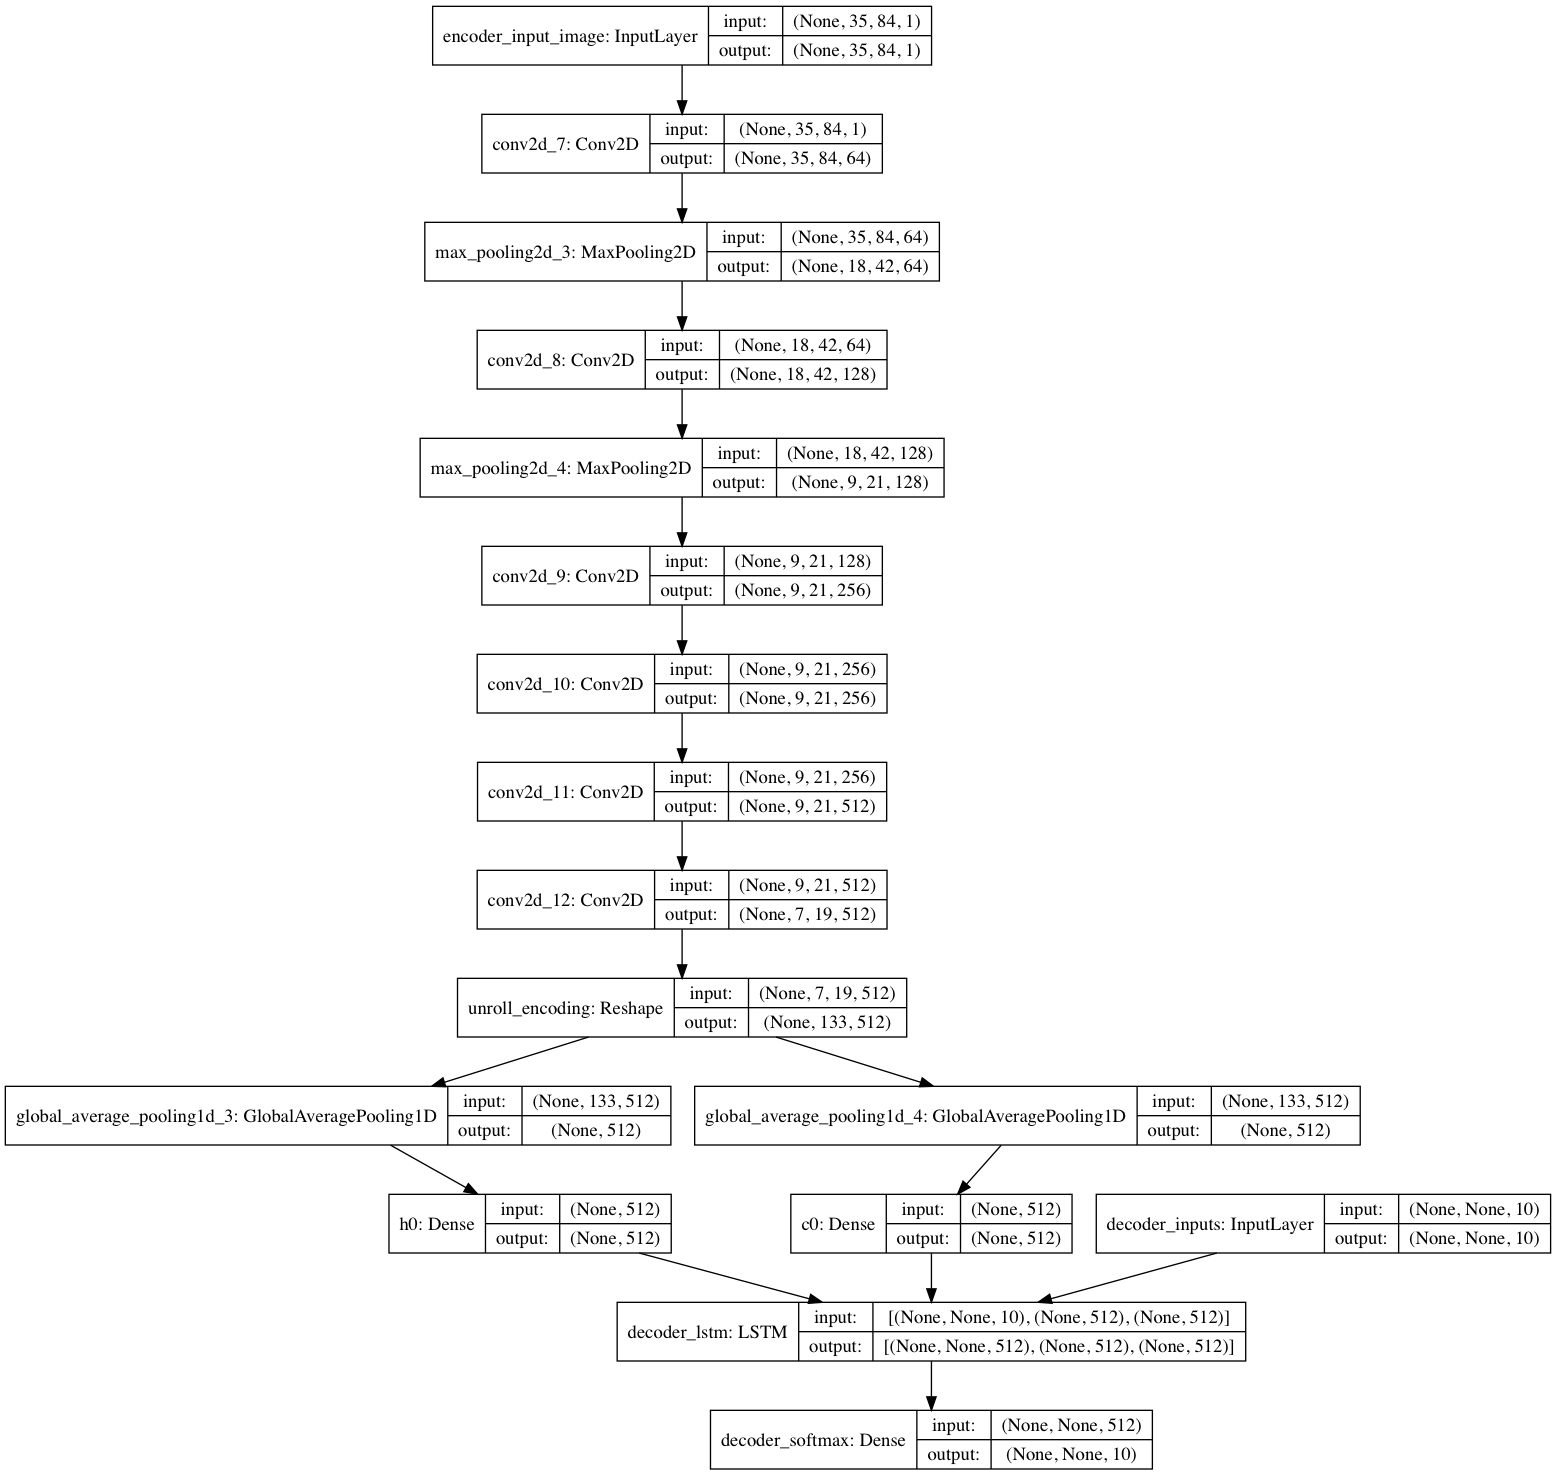

In [101]:
## Visualize the training model

from keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='training_model.png', show_shapes=True)

Image(filename='training_model.png') 


In [102]:
### Time for inference


# Step 1. Set up the encoder as a separate model:

encoder_model = Model(encoder_inputs, [h0, c0, encoded]) #encoded is included for debugging purposes




In [103]:
# Step 2. Set up the decoder as a separate model.

# The decoder takes three inputs: the input_state_h, input_state_c and 

latent_dim = 512
decoder_state_input_h = Input(shape=(latent_dim,), name='decoder_state_input_h')
decoder_state_input_c = Input(shape=(latent_dim,), name='decoder_state_input_c')
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# Will be a one-hot encoded vector
decoder_inputs = Input(shape=(None, num_decoder_tokens), name='decoder_inputs')

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)

decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)


In [104]:
## Plot the inference Encoder Model 
plot_model(encoder_model, to_file='inference_encoder_model.png', show_shapes=True)

## Uncomment for plotting
#Image(filename='inference_encoder_model.png') 



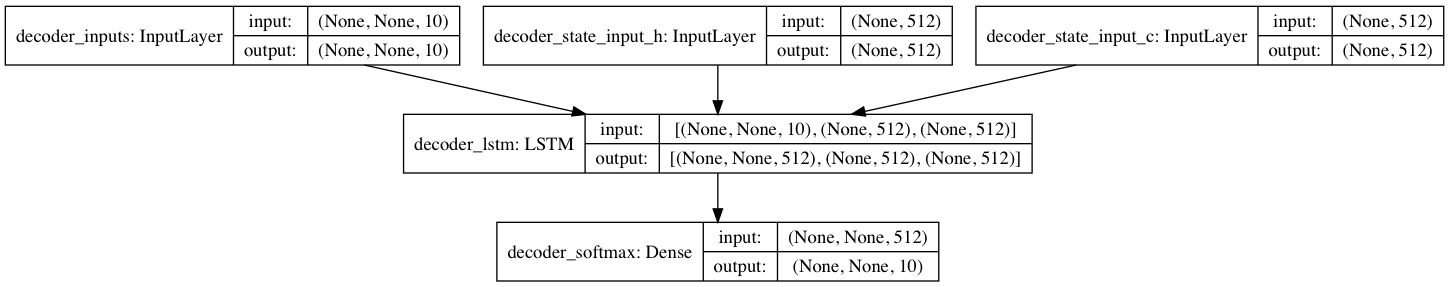

In [69]:
## Plot the inference Decoder model
plot_model(decoder_model, to_file='inference_decoder_model.png', show_shapes=True)
Image(filename='inference_decoder_model.png') 


In [107]:
## Decode sequence using our two models

def decode_sequence(input_seq):
	# Encode the input as state vectors.
	hidden_0, memory_0, encoded = encoder_model.predict(input_seq)

	states_value = [hidden_0, memory_0]

    # Generate empty target sequence of length 1.
	target_seq = np.zeros((1, 1, num_decoder_tokens))
    #Populate the first character of target sequence with the start character.
	target_seq[0, 0, target_token_index['**start**']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
	stop_condition = False
	decoded_sentence = ''
	while not stop_condition:
		#print(target_seq)
		output_tokens, h, c = decoder_model.predict(
			[target_seq] + states_value)

        # Sample a token
		#print(output_tokens)
		sampled_token_index = np.argmax(output_tokens[0, -1, :])
		sampled_char = reverse_target_token_index[sampled_token_index]
		decoded_sentence = decoded_sentence + ' ' + sampled_char

        # Exit condition: either hit max length
        # or find stop character.
		if (sampled_char == '**end**' or
			len(decoded_sentence.split()) > max_decoder_seq_length):
			stop_condition = True

        # Update the target sequence (of length 1).
		target_seq = np.zeros((1, 1, num_decoder_tokens))
		target_seq[0, 0, sampled_token_index] = 1.

        # Update states
		states_value = [h, c]

	return decoded_sentence


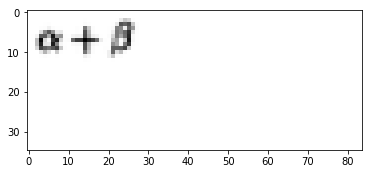

-
Target sentence: **start** \alpha + \beta **end**
Decoded sentence:  \frac { 1 } { 2 } **end**


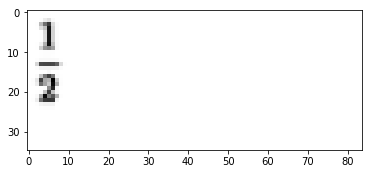

-
Target sentence: **start** \frac { 1 } { 2 } **end**
Decoded sentence:  \frac { 1 } { 2 } **end**


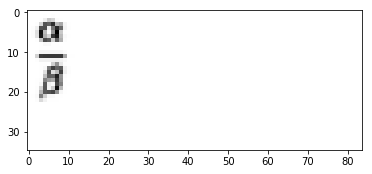

-
Target sentence: **start** \frac { \alpha } { \beta } **end**
Decoded sentence:  \frac { 1 } { 2 } **end**


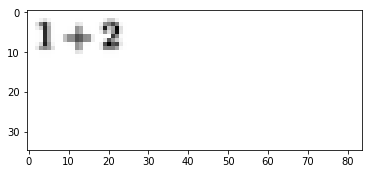

-
Target sentence: **start** 1 + 2 **end**
Decoded sentence:  \frac { 1 } { 2 } **end**


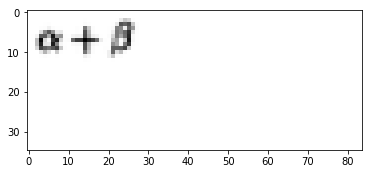

-
Target sentence: **start** \alpha + \beta **end**
Decoded sentence:  \frac { 1 } { 2 } **end**


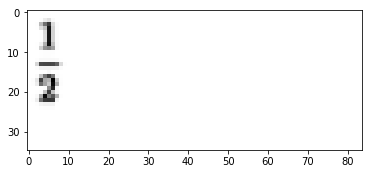

-
Target sentence: **start** \frac { 1 } { 2 } **end**
Decoded sentence:  \frac { 1 } { 2 } **end**


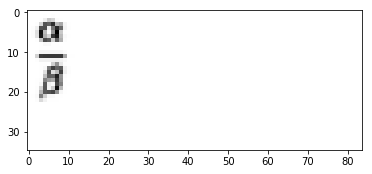

-
Target sentence: **start** \frac { \alpha } { \beta } **end**
Decoded sentence:  \frac { 1 } { 2 } **end**


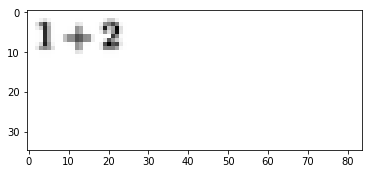

-
Target sentence: **start** 1 + 2 **end**
Decoded sentence:  \frac { 1 } { 2 } **end**


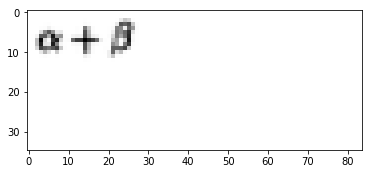

-
Target sentence: **start** \alpha + \beta **end**
Decoded sentence:  \frac { 1 } { 2 } **end**


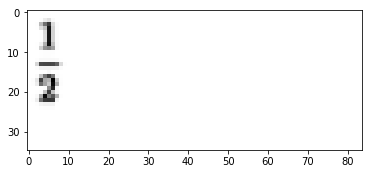

-
Target sentence: **start** \frac { 1 } { 2 } **end**
Decoded sentence:  \frac { 1 } { 2 } **end**


In [115]:
num_test = 10

for seq_index in range(num_test):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]

    plt.imshow(np.squeeze(input_seq), cmap='gray')
    plt.show()
    
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Target sentence: ' + str(target_texts[seq_index]))
    print('Decoded sentence: ' + str(decoded_sentence))